In [2]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import shapely
import momepy
import matplotlib.pyplot as plt

<h2>Creating GeoDataframes</h2>

In [35]:
urlBike = "https://maps.amsterdam.nl/open_geodata/geojson_latlng.php?KAARTLAAG=FIETSNETTEN&THEMA=fietsnetten"
urlCity = "https://maps.amsterdam.nl/open_geodata/geojson_latlng.php?KAARTLAAG=HOEGROOT&THEMA=hoegroot"
amBike = gpd.read_file(urlBike)
amCity = gpd.read_file(urlCity)

In [36]:
amBike = amBike.to_crs('EPSG:32632')
amCity = amCity.to_crs('EPSG:32632')

In [37]:
amCity = amCity[amCity['GEMEENTE_ID'] == 1]

In [10]:
seaBike = gpd.read_file("SDOT_Bike_Facilities_existing.geojson")
seaMulti = gpd.read_file("SDOT_Bike_Facilities_multiuse.geojson")
seaCity = gpd.read_file("Seattle_Area_Polygon_-142470933516081067.geojson")

In [11]:
seaBike = seaBike.to_crs('EPSG:32610')
seaMulti = seaMulti.to_crs('EPSG:32610')
seaCity = seaCity.to_crs('EPSG:32610')

<h3>Plots</h3>

<Axes: >

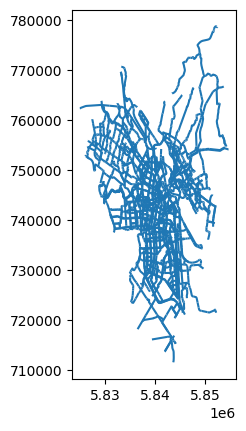

In [38]:
amBike.plot()

<Axes: >

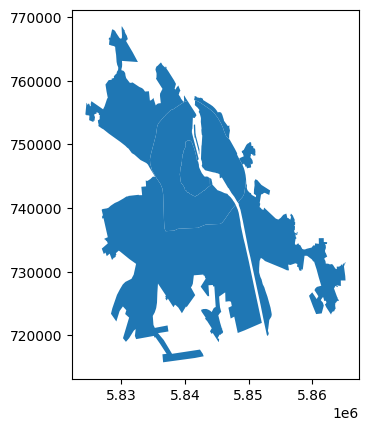

In [39]:
amCity.plot()

<Axes: >

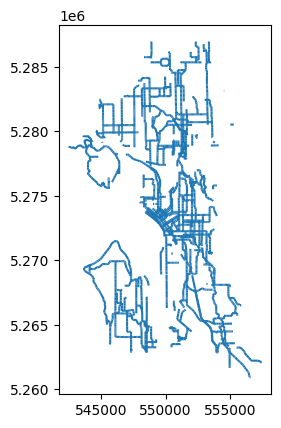

In [15]:
seaBike.plot()

<Axes: >

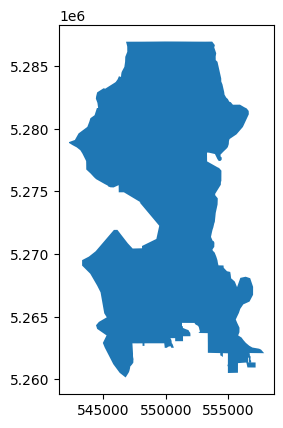

In [16]:
seaCity.plot()

<h2>Area Comparisions</h2>

Data from Amsterdam gave larger area than expected (based on Google area). Maybe from including too much water. Calculated data from Open Street Polygons. Now the Seattle area is too high. To make the cities easier to compare, I will use the area of the GeoJSON provided by the City of Seattle and use the Open Street Map Polyfon for Amsterdam. 

In [40]:
seaArea = seaCity.area / 1000000
seaArea[0]

238.03031395933098

<Axes: >

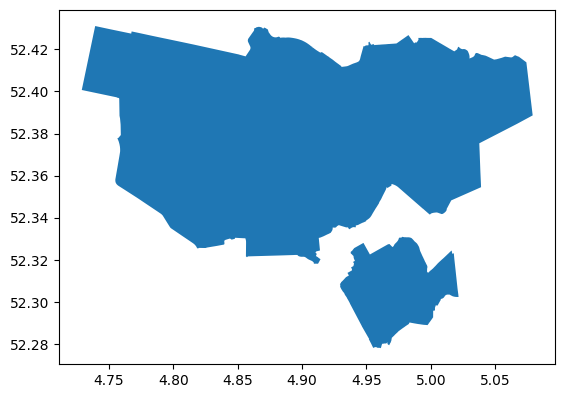

In [41]:
#Amsterdam Open Street Polygon
aArea = ox.geocode_to_gdf('Amsterdam, North Holland, Netherlands')
aArea.plot()

In [43]:
aArea = aArea.to_crs('EPSG:32632')
aArea_km = aArea.area/1000000
aArea_km[0]

219.74511133494627

<h3>Area Analysis</h3>

In [45]:
#buffer bike data (0.25 miles) and get percentage of area

<h3>Bad Area Caclulations</h3>

<Axes: >

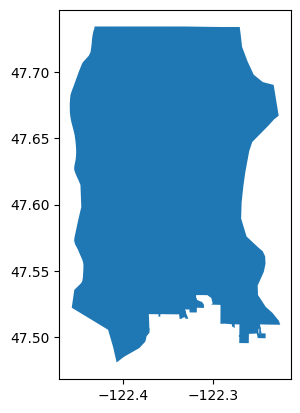

In [30]:
#Seattle Open Street Polygon
sArea = ox.geocode_to_gdf('Seattle, Washington, USA')
sArea.plot()

In [29]:
#too big
sArea = sArea.to_crs('EPSG:32610')
sArea_km = sArea.area/1000000
sArea_km

0    373.115282
dtype: float64

In [44]:
amArea = amCity.area / 1000000
amArea[0]

819.8039753793031

<h2>Creating graph datasets</h2>

In [18]:
amBike["start"] = shapely.get_point(amBike.geometry, 0)
amBike["end"] = shapely.get_point(amBike.geometry, -1)

In [19]:
amBike.head()

,Label,Soort,Soortcode,Richtingen,Verharding,HoofdPlus,Stadsdeel,Lengte_m,geometry,start,end
0,Brom-/Fietspad - 1r - Onbekend,Brom-/Fietspad,11,1,Onbekend,P,X,128.10,"LINESTRING (5830050.125 744675.513, 5830057.85...",POINT (5830050.125 744675.513),POINT (5830206.278 744537.103)
1,Fiets op rijbaan - 1r - Onbekend,Fiets op rijbaan,40,1,Onbekend,P,X,69.95,"LINESTRING (5830206.278 744537.103, 5830214.91...",POINT (5830206.278 744537.103),POINT (5830299.873 744498.462)
2,Fiets op rijbaan - 1r - Onbekend,Fiets op rijbaan,40,1,Onbekend,P,X,49.53,"LINESTRING (5830206.278 744537.103, 5830219.09...",POINT (5830206.278 744537.103),POINT (5830270.605 744492.147)
3,Brom-/Fietspad - 1r - Asfalt-Grijs,Brom-/Fietspad,11,1,Asfalt-Grijs,P,X,22.03,"LINESTRING (5842363.408 717982.009, 5842374.91...",POINT (5842363.408 717982.009),POINT (5842387.526 717949.429)
4,Fietspad - 1r - Asfalt-Rood,Fietspad,10,1,Asfalt-Rood,P,X,66.78,"LINESTRING (5831685.550 739136.073, 5831690.61...",POINT (5831685.550 739136.073),POINT (5831742.455 739015.553)


In [20]:
amTest = amBike.mask(amBike.eq('None')).dropna()

In [21]:
G = nx.from_pandas_edgelist(amTest, source='start', target='end')
#if two way do opposite

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


KeyError: 'crs'

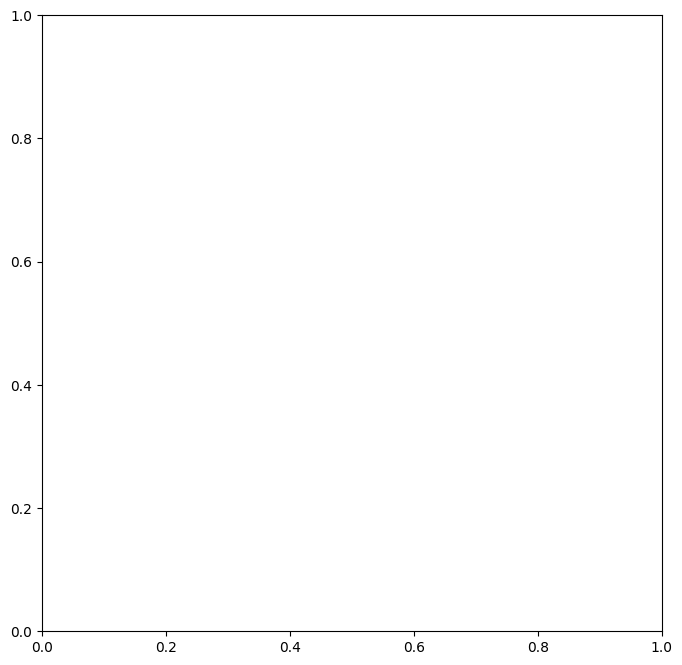

In [57]:
# Plot map
fig, ax = ox.plot_graph(G, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

Stuggling to plot graph. Networkx draw funtion does things weird

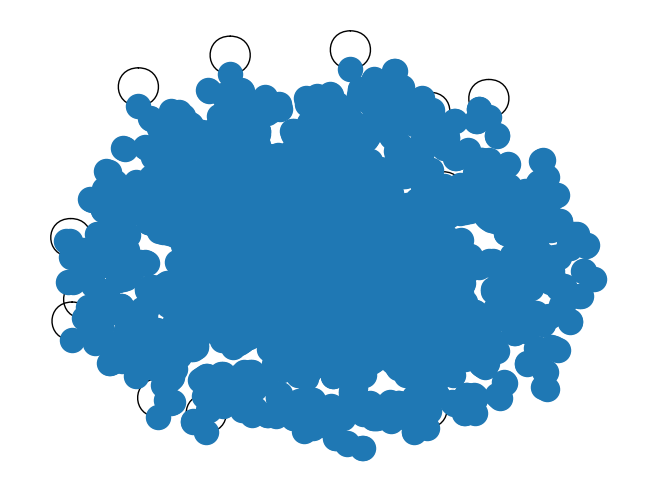

In [59]:
nx.draw(G)

<h2>Unsucessful Attempts</h2>

In [42]:
# Add nodes
unique_points = set(amBike['start'].tolist() + amBike['end'].tolist())
for point in unique_points:
    G.add_node(point)

# Add edges
for idx, row in amBike.iterrows():
    start = row['start']
    end = row['end']
    geometry = row['geometry']
    
    # If the linestring is represented by multiple points
    for u, v in zip(geometry.coords[:-1], geometry.coords[1:]):
        G.add_edge(u, v)
        G.add_edge(v, u)  # Make sure to add the reverse edge for bidirectionality

# Now you have a graph where each linestring is represented as

ValueError: None cannot be a node

In [35]:
# Draw the graph
pos = nx.spring_layout(G)  # Layout algorithm
nx.draw_networkx_nodes(G, pos, node_size=.5)  # Node size set to 2pt
nx.draw_networkx_edges(G, pos, width=1)  # Edge width set to 1pt

# Display the graph
plt.axis("off")
plt.show()

KeyboardInterrupt: 

In [ ]:
nx.draw(G, pos, ax = None, node_size = 1, node_color = 'lightgreen')

In [25]:
# Create an empty MultiDiGraph
G = nx.MultiDiGraph()

# Iterate through each row in the GeoDataFrame
for index, row in amBike.iterrows():
    # Extract the LineString geometry
    line = row['geometry']
    
    # Extract the coordinates of the LineString
    coordinates = list(line.coords)
    
    # Iterate through each pair of consecutive coordinates
    for i in range(len(coordinates) - 1):
        # Add the nodes to the graph if they don't already exist
        start_node = coordinates[i]
        end_node = coordinates[i + 1]
        G.add_node(start_node)
        G.add_node(end_node)
        
        # Add the edge to the graph
        G.add_edge(start_node, end_node)
        
        # Optionally, you can associate attributes with nodes and edges
        # For example, if your GeoDataFrame has additional columns, you can add them as attributes
        # For instance, assuming there's a column named "attribute" in your GeoDataFrame
        # You can access it like this:
        # attribute_value = row['attribute']
        # Then you can add it as an attribute to nodes or edges
        
        # Example:
        # G.nodes[start_node]['attribute'] = attribute_value
        # G.edges[start_node, end_node]['attribute'] = attribute_value

# Now you have a MultiDiGraph G created from the LineString geometries in your GeoDataFrame

NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

In [34]:
# Create an empty MultiDiGraph
G = nx.MultiDiGraph()

# Iterate through each row in the GeoDataFrame
for index, row in amBike.iterrows():
    # Extract the geometry
    geometry = row['geometry']
    
    # Check if the geometry is a MultiLineString
    if geometry.geom_type == 'MultiLineString':
        # If it's a MultiLineString, iterate over each LineString
        for line in geometry:
            # Extract the coordinates of the LineString
            coordinates = list(line.coords)
            # Iterate through each pair of consecutive coordinates
            for i in range(len(coordinates) - 1):
                # Add nodes and edges to the graph
                start_node = coordinates[i]
                end_node = coordinates[i + 1]
                G.add_node(start_node)
                G.add_node(end_node)
                G.add_edge(start_node, end_node)
    else:
        # If it's a single LineString, process it as before
        line = geometry
        coordinates = list(line.coords)
        for i in range(len(coordinates) - 1):
            start_node = coordinates[i]
            end_node = coordinates[i + 1]
            G.add_node(start_node)
            G.add_node(end_node)
            G.add_edge(start_node, end_node)

# Now you have a MultiDiGraph G created from the LineString and MultiLineString geometries in your GeoDataFrame

TypeError: 'MultiLineString' object is not iterable

In [30]:
nodes, edges, W = momepy.nx_to_gdf(amBike, spatial_weights=True)


# Read in example street network from GeoPackage
streets = gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")

# Construct the primal graph
G_primal = momepy.gdf_to_nx(streets, approach="primal")

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
streets.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Graph")[i])
    facet.axis("off")
    try:  # For issues with downloading/parsing in CI
        add_basemap(facet)
    except:
        pass
nx.draw(
    G_primal, {n: [n[0], n[1]] for n in list(G_primal.nodes)}, ax=ax[1], node_size=50
)

AttributeError: 'GeoDataFrame' object has no attribute 'graph'

In [18]:
# Create a graph
G = nx.Graph()

# Iterate over GeoDataFrame features
for idx, row in amBike.iterrows():
    # Extract geometry
    geom = row.geometry

    # Extract endpoints of LineString geometries
    if geom.geom_type == 'LineString':
        coords = list(geom.coords)
        start_node = coords[0]
        end_node = coords[-1]

        # Add nodes and edges
        G.add_edge(start_node, end_node, geometry=geom)

<h2>Open Street Data</h2>

In [1]:
import numpy as np
import geopandas as gpd

import osmnx as ox
import networkx as nx

import os
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiLineString
from descartes import PolygonPatch

import matplotlib.pyplot as plt
import folium

<h3>Seattle</h3>

In [66]:
seattleG = ox.graph_from_place('Seattle, Washington, USA', network_type='bike')

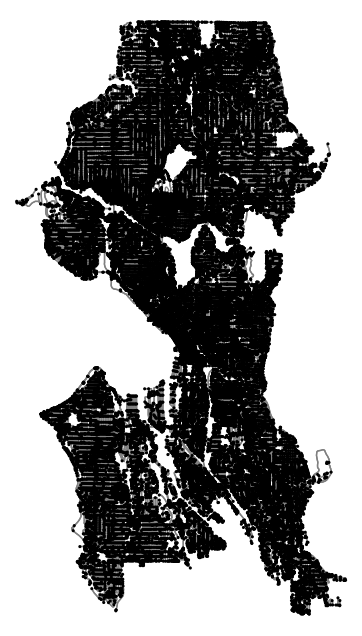

In [67]:
# Plot map
fig, ax = ox.plot_graph(seattleG, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

In [68]:
sCoords = [47.605465173774206, -122.3192423656039]
sNode = ox.distance.nearest_nodes(seattleG, X=sCoords[1], Y=sCoords[0], return_dist=False)

In [69]:
nodes = ox.graph_to_gdfs(seattleG, nodes=True, edges=False)
edges = ox.graph_to_gdfs(seattleG, nodes=False, edges=True)

In [70]:
travel_speed = 16
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in seattleG.edges.data():
    data['time'] = data['length'] / meters_per_minute

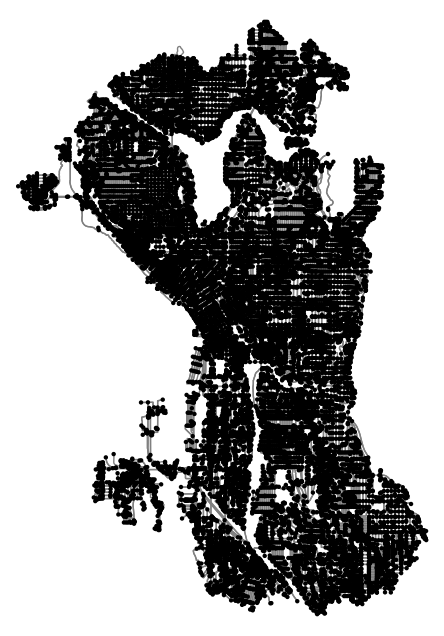

In [75]:
subgraph = nx.ego_graph(seattleG, sNode, radius=30, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

In [76]:
trip_times = [5, 10, 15, 20, 25, 30]  # in minutes
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_78626/3036243802.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)


In [77]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph1 = nx.ego_graph(seattleG, sNode, radius=trip_time, distance="time")
    for node in subgraph1.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in seattleG.nodes()]
ns = [10 if node in node_colors else 0 for node in seattleG.nodes()]

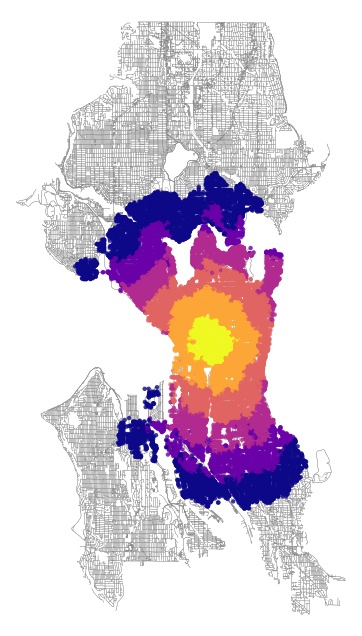

In [78]:
fig, ax = ox.plot_graph(seattleG, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

In [54]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, sNode, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [55]:
isochrone_polys = make_iso_polys(seattleG, edge_buff=25, node_buff=0, infill=True)

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

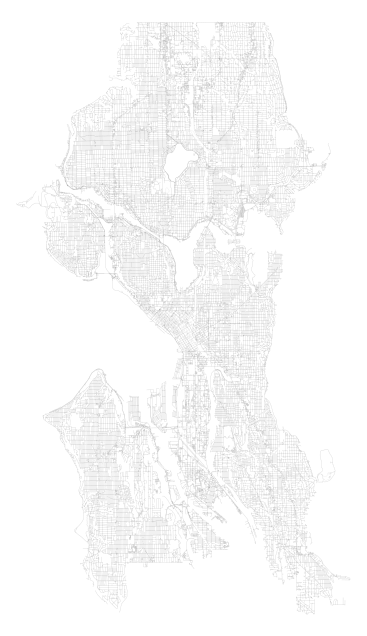

In [56]:
fig, ax = ox.plot_graph(seattleG, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

<h3>Amsterdam</h3>

In [64]:
AmsterG = ox.graph_from_place('Amsterdam, North Holland, Netherlands', network_type='bike')

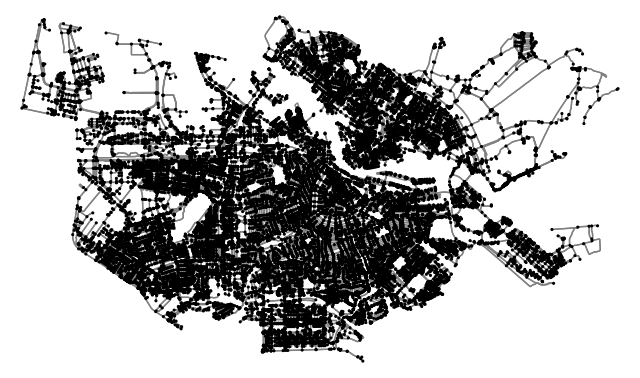

In [65]:
# Plot map
fig, ax = ox.plot_graph(AmsterG, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

In [79]:
aCoords = [52.367968834647755, 4.903949560729881]
aNode = ox.distance.nearest_nodes(AmsterG, X=aCoords[1], Y=aCoords[0], return_dist=False)

In [ ]:
#project after creating node

In [80]:
nodes = ox.graph_to_gdfs(AmsterG, nodes=True, edges=False)
edges = ox.graph_to_gdfs(AmsterG, nodes=False, edges=True)

In [81]:
travel_speed = 16
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in AmsterG.edges.data():
    data['time'] = data['length'] / meters_per_minute

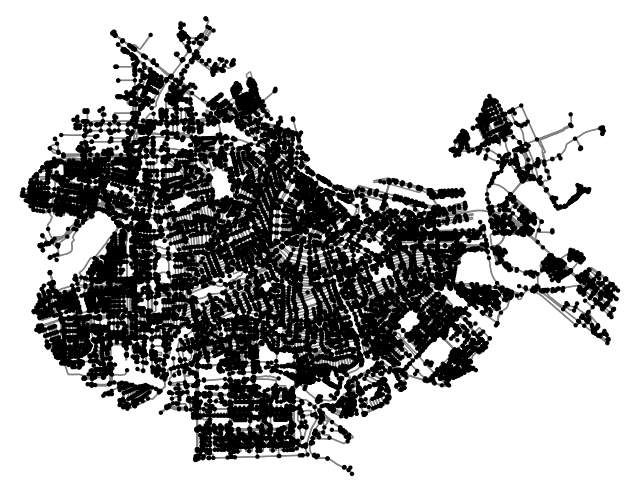

In [84]:
subgraph = nx.ego_graph(AmsterG, aNode, radius=30, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

In [85]:
trip_times = [5, 10, 15, 20, 25, 30]  # in minutes
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_78626/3036243802.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)


In [86]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph2 = nx.ego_graph(AmsterG, aNode, radius=trip_time, distance="time")
    for node in subgraph2.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in AmsterG.nodes()]
ns = [10 if node in node_colors else 0 for node in AmsterG.nodes()]

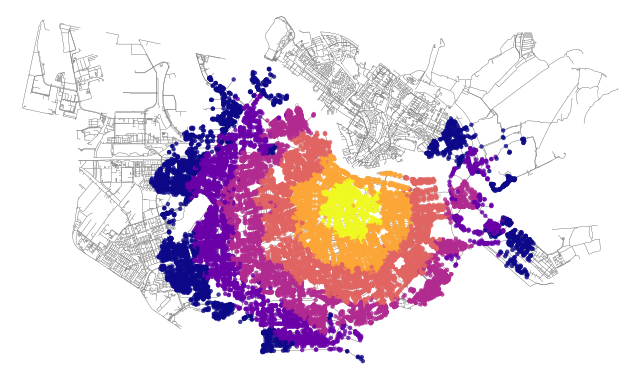

In [87]:
fig, ax = ox.plot_graph(AmsterG, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

In [90]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, aNode, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [91]:
isochrone_polys = make_iso_polys(AmsterG, edge_buff=25, node_buff=0, infill=True)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [ ]:
fig, ax = ox.plot_graph(AmsterG, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()